# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: A. Gramfort, M. Massias, P. Ablin

## Aim

The aim of this material is to code 
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal coordinate descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 11th of november at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 5 novembre 2018**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "sofiane"
ln1 = "ennadir"
fn2 = "mohammed-amine"
ln2 = "abboudi"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_ennadir_sofiane_and_abboudi_mohammed-amine.ipynb


In [2]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# the usual functions:

from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b

## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
    $$\hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 $$

We ask you to code:
- cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$
- greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.


**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

In [4]:
n_features = 100
np.random.seed(1970)
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=False)

In [5]:
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    residuals = b - A.dot(w)
    
    # TODO
    lips_const = np.linalg.norm(A,axis=0) ** 2
    # END TODO
    
    for t in range(n_iter):
        j = t % n_features
        # TODO
        old_w_j = w[j]
        w[j] += np.dot(residuals, A[:,j]) / lips_const[j]
        # update residuals:
        residuals -= A[:,j] * (w[j] - old_w_j)
        # END TODO
        
        if t % n_features == 0:
            all_objs.append((residuals ** 2).sum() / 2.)
            
    return w, np.array(all_objs)


def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    
    gradient = A.T.dot(A.dot(w) - b)
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date
    
    # TODO
    lips_const = np.linalg.norm(A,axis=0) ** 2
    # END TODO 
    
    for t in range(n_iter):
        # TODO
        # choose feature j to update: 
        j = np.argmax(abs(gradient))
        old_w_j = w[j]
        w[j] -= gradient[j] / lips_const[j]
        # update gradient:
        gradient += gram[:,j] * (w[j] - old_w_j)
        # END TODO
        
        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)
    
    return w, np.array(all_objs)


- compute a precise minimum with your favorite solver
- compare the performance of cyclic and greedy CD

- from a practical point of view, could you use greedy CD for ridge logistic regression? to solve OLS, but with 100,000 features? Explain your answers.

<div class="alert alert-info">
<span class="label label-primary" style="font-size:15px;">Compute the Precise minimum with your favorite solver and compare</span>
<ul>
We are going to use the ElasticNet to solve our problem and then compare it with the results that we got using our coded functions.
<li>
    We recall that in order to have the same function to be minimized, the two parameters of ElasticNet Alpha and L1_ratio should have a value close to 0. 
</li>
    
<li>
    In the first part, we are comparing the three methods in term of coefs and in terms of iterations. 
</li>
  
<li>
    In the second part, we are trying to see the impact of the Parameter Alpha.
</li>
    
</ul>
</div>

0.02327026881771773
0.03605618070821329
19.0


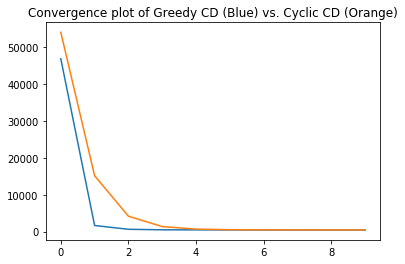

In [6]:
from sklearn.linear_model import ElasticNet, LinearRegression

reg = ElasticNet(l1_ratio=0.001, alpha=0.001, random_state=42)
# reg = LinearRegression()
x_final1, _ = greedy_cd(A, b, 1000)
plt.plot(_)
x_final2, _ = cyclic_cd(A, b, 1000)
plt.plot(_)
plt.title('Convergence plot of Greedy CD (Blue) vs. Cyclic CD (Orange)')
reg.fit(A,b)

print(np.linalg.norm((reg.coef_ - x_final1))) # Distance between precise minimum and Greedy CD solution
print(np.linalg.norm((reg.coef_ - x_final2))) # Distance between precise minimum and Cyclic CD solution

print(np.linalg.norm((reg.n_iter_ - len(_)))) # Difference of number of iterations

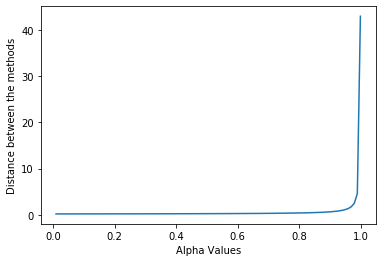

In [8]:
alpha_values = np.arange(0.001, 1, 0.01)
_ = []
for alpha in alpha_values:
    reg = ElasticNet(l1_ratio=0.001, alpha=alpha, random_state=42)
    _.append(np.linalg.norm((reg.fit(A,b).coef_ - x_final1)))
    
plt.plot(1-alpha_values, [1/x for x in _])
plt.xlabel('Alpha Values')
plt.ylabel('Distance between the methods')
plt.show()

<div class="alert alert-info">
<span class="label label-primary" style="font-size:15px;">Ridge Logistic Regression</span>
<ul>

<li>
For logistic ridge regression, the objective function is as follows : 
$$ f(w) = \frac{1}{n}\sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- b_i w^\top a_i} )  + \frac{\lambda}{2} \Vert w \Vert_2^2 $$
    </li>
<li>
$f$ is convex and differentiable, while the regularization term is convex and separable. It is therefore possible to apply greedy CD.
The gradient is:

$$ \nabla_j f(w) = \frac{1}{n} \sum_{i=1}^{n} - \frac{b_i a_{ij}}{1 + \exp(b_i a_i^\top w)}  + \lambda w_j. $$

</li>
    
Since we can explicitely write the gradient, we can use the same code as before and update as was the case for OLS.
    

<li>From a practical point of view, if the number of features is much greater than the number of samples, it is better not to use coordinate methods as opposed to sample-wise optimisation (SGD) since the cost of a single iteration is independent from the number of features and each the coordiant is chosen based on the maximal gradient. It is therefore possible to achieve convergence faster than cyclic CD or gradient descent when comparing in terms of epochs.
    </li>
</ul>
</div>

## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving 
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$
1) Assuming uniqueness of the solution, show that:
$$ \lambda \geq \lambda_{max} \Leftrightarrow \hat w = 0$$
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.


You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert (w_1)  \times \dots \times \partial \vert \cdot \vert (w_p) $$
where $\times$ is the Cartesian product between sets,
and $$ \partial \vert \cdot \vert (w_j) = 
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0, 
         \\ & [-1, 1] &\mathrm{otherwise.} 
\end{cases}
$$


(it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)$)

<div class="alert alert-info">
<span class="label label-primary" style="font-size:15px;">Question 1</span>
<ul>

We have $ \partial \Vert \cdot \Vert_1 (\mathbf{0}_p) = [-1,1]^p \Leftrightarrow \forall 1\leq j\leq p : |(\partial \vert \cdot \vert (w_j))|\leq1$ (*) and since $\hat w = \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$ :

$$ \hat w = 0 \Leftrightarrow \nabla f(\mathbf{0_p}) = 0 \Leftrightarrow \sum_{i=1}^{n} \frac{y_i x_i} { 1 + e^{(- y_i \mathbf{0_p}^\top x_i)} }  - \lambda \partial \Vert \cdot \Vert_1 (\mathbf{0}_p) = 0  \\ \Leftrightarrow
\sum_{i=1}^{n} \frac{y_i x_i}{2} = \frac{1}{2} X^\top y = \lambda \partial \Vert \cdot \Vert_1 (\mathbf{0}_p) = 0$$
by replacing element-wise in (*):
$$
    \Leftrightarrow \forall 1\leq j\leq p : \frac{1}{2} |X_j^\top y| \leq \lambda \Leftrightarrow \frac{1}{2} \Vert X^\top y\Vert_\infty\leq \lambda
$$
   
</ul>
</div>

2) Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.

<div class="alert alert-info">
<span class="label label-primary" style="font-size:15px;">Question 2</span>
<ul>

We have : $\Vert\nabla_j ^2 f(w)\Vert^2_2 \leq \gamma_j\quad ;\quad\forall 1\leq j\leq p$.
$$
\nabla_j f(\mathbf{w}) = \sum_{i=1}^{n} \frac{-y_i . X_{ij}} { 1 + e^{( y_i \mathbf{w}^\top x_i)} } \Rightarrow \nabla_j ^2 f(w) = \sum_{i=1}^{n} y_i^2 . X_{ij}^2.\phi^{''}(y_i.x_i^\top w),\quad \phi(x) = \log (1+e^{-x}) \begin{cases}\phi^{''}(x) = \frac{e^x}{(1+e^x)^2}, 
         \\ \forall x \in \mathbb{R} \quad \vert\phi^{''}(x)\vert\leq\frac{1}{4}
\end{cases} \Rightarrow \vert \nabla_j ^2 f(w)\vert \leq \frac{1}{4} \sum_{i=1}^{n} X_{ij}^2 = \frac{1}{4} \Vert X_j\Vert_2^2
$$
We can therefore conclude that:
$$\gamma_j \approx \frac{1}{4} \Vert X_j\Vert_2^2$$
   
</ul>
</div>

You are now ready to code cyclic proximal coordinate descent for sparse Logistic regression:

**WARNING**: the Lasso means linear regression (quadratic fitting term) with L1 penalty. Sparse logistic regression means logistic regression with L1 penalty.

In [9]:
np.random.seed(1970)
X, y = simu(coefs, n_samples=1000, for_logreg=True)
lambda_max = norm(X.T.dot(y), ord= np.inf) / 2.
lamb = lambda_max / 20.  
# much easier to parametrize lambda as a function of lambda_max than 
# to take random values like 0.1 in previous Labs


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.sign(x) * np.maximum(0., np.abs(x) - u)


def cd_logreg(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    Xw = X.dot(w)
    all_objs = np.zeros(n_iter)
    
    # TODO
    lips_const = np.linalg.norm(X,axis=0) ** 2 * 1 / 4
    # END TODO
    
    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            # TODO
            
            grad_j = (- y * X[:,j] * sigmoid(- y * Xw)).sum()
            
            w[j] = soft_thresh(old_w_j - (1 / lips_const[j]) * grad_j, lamb/lips_const[j])
            
            if old_w_j != w[j]:
                Xw += X[:,j] * (w[j] - old_w_j)
            #END TODO
            
        all_objs[t] = np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1)
    
    return w, all_objs

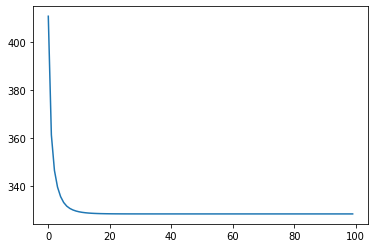

In [10]:
x_final3, _ = cd_logreg(X, y, lamb, 100)
plt.plot(_)

# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to solve the Lasso on a real dataset, called _leukemia_.

In [11]:
from sklearn.datasets import fetch_openml

leuk = fetch_openml("leukemia")

X = np.asfortranarray(leuk.data)
y = np.ones(leuk.target.shape)
y[leuk.target == leuk.target[0]] = -1.

In [12]:
print(X.shape)

lambda_max_lasso = norm(X.T.dot(y), ord=np.inf)
lambd = lambda_max_lasso / 5.

(72, 7129)


Code:
- a simple proximal gradient solver for the Lasso
- a prox CD solver for the Lasso
and compare them on this dataset. 
Do the plots in terms of epochs, not updates (to be fair to CD).

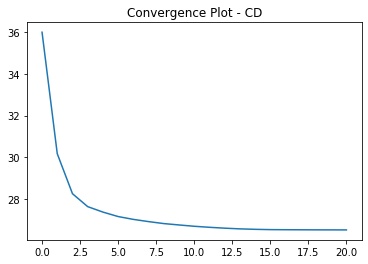

In [13]:
def cd_lasso(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    Xw = X.dot(w)
    all_objs = [0.5 * np.linalg.norm(Xw - y) ** 2 + lamb * norm(w, ord=1)]
    
    lips_const =  (np.linalg.norm(X, axis=0) ** 2)
   

   
    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            
            grad_j= X[:,j].T.dot(Xw-y)
            w[j] = soft_thresh(old_w_j-grad_j/lips_const[j] , lamb/lips_const[j])
            #gradient += gram[:,j] *(w[j]-old_w_j)
           
            if old_w_j != w[j]:
                Xw += X[:,j]*(w[j]-old_w_j)
           
        all_objs.append(0.5 * np.linalg.norm(Xw - y) ** 2 + lamb * norm(w, ord=1))
   
    return w, np.array(all_objs)


w,all_obj = cd_lasso(X, y, lambd, 20)

plt.plot(all_obj)
plt.title('Convergence Plot - CD')
plt.show()

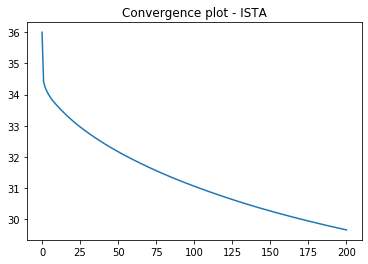

In [15]:
def ista(X, y, lamb, n_iter):
    
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    all_objs = [0.5 * np.linalg.norm(X.dot(w) - y) ** 2 + lamb * np.linalg.norm(w, ord=1)]
    
    lips_const = np.linalg.norm(X, ord=2) ** 2  # Lipschitz constant

    for t in range(n_iter):
        
        w = soft_thresh(w + np.dot(X.T, y - X.dot(w)) / lips_const, lamb / lips_const)
        this_obj = 0.5 * np.linalg.norm(X.dot(w) - y) ** 2 + lamb * np.linalg.norm(w, ord=1)
        
        all_objs.append(this_obj)
        
    return w, np.array(all_objs)

w_ista, ista_loss = ista(X, y, lambd, 200)

plt.plot(ista_loss)
plt.title('Convergence plot - ISTA')
plt.show()

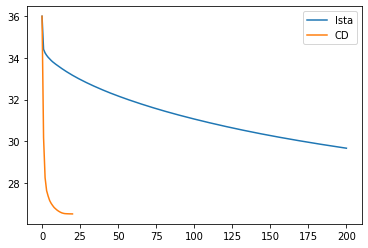

In [16]:
plt.plot(ista_loss)
plt.plot(all_obj)

plt.legend(['Ista', 'CD'])
plt.show()

<div class="alert alert-info">
<span class="label label-primary" style="font-size:15px;">Comparaison between the ISTA and the CD</span>
<ul>

<li>
    Through the plots, we can remark that the CD Algorithm converges faster than the ISTA Algorithm. This can be explained by the learning rate that is used in each case. In fact, for the CD, in order to have the Lips Constant, we only considered one direction (One feature), while in the ISTA Algorithm, we consider the complete matrix making the learning rate for the ISTA much smaller (3 Orders of magnitude) than the one used in the CD Algorithm.
    </li>


    
</ul>
</div>